In [1]:
import os
import sys
sys.path.append('../../denoising')
from torch.backends import cudnn
from loader import get_loader
from solver import Solver
from networks import RED_CNN
from subprocess import run
import torch
import numpy as np

from shutil import rmtree
rmtree('models')

for lmbda in range(11):
    lmbda/=10
    run(['python', '../../denoising/main.py',
         '--data_path' ,'/gpfs_projects/brandon.nelson/Mayo_LDGC/images',
         '--saved_path', '/gpfs_projects/brandon.nelson/Mayo_LDGC/numpy_files',
         '--load_mode', '1',
         '--save_path', f'models/lambda{int(lmbda*100):03d}',
         '--augment', f'{lmbda}'])

In [2]:
from collections import OrderedDict

def load_model(save_path, iter_=13000, multi_gpu=False):
    REDCNN = RED_CNN()
    f = os.path.join(save_path, 'REDCNN_{}iter.ckpt'.format(iter_))
    if multi_gpu:
        state_d = OrderedDict()
        for k, v in torch.load(f):
            n = k[7:]
            state_d[n] = v
        REDCNN.load_state_dict(state_d)
        return REDCNN
    else:
        REDCNN.load_state_dict(torch.load(f))
        return REDCNN

In [3]:
from pathlib import Path
for lmbda in range(11):
    lmbda/=10
    model_path = Path(f'models/lambda{int(lmbda*100):03d}')
    model = load_model(model_path)
    print(model_path)

models/lambda000
models/lambda010
models/lambda020
models/lambda030
models/lambda040
models/lambda050
models/lambda060
models/lambda070
models/lambda080
models/lambda090
models/lambda100


In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import SimpleITK as sitk

base_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation')
meta = pd.read_csv(base_dir / 'metadata.csv')
meta = meta[meta.recon == 'fbp']
meta.head()

,Code #,Name,age [year],gender,weight [kg],height [cm],BMI,weight percentile,ethnicity,effective diameter [cm],Dose [%],recon,phantom,file,simulated,FOV [cm],kernel,scanner
2,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,10,fbp,anthropomorphic,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,14.43,NaN,NaN
5,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,40,fbp,anthropomorphic,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,14.43,NaN,NaN
8,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,25,fbp,anthropomorphic,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,14.43,NaN,NaN
11,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,55,fbp,anthropomorphic,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,14.43,NaN,NaN
14,Reference newborn,male infant,0.166,M,3.8,52.0,14.1,36.0,NaN,11.1,100,fbp,anthropomorphic,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,True,14.43,NaN,NaN


In [5]:
meta.phantom.unique()

array(['anthropomorphic', 'MITA-LCD', 'uniform', 'ACR464', 'CTP404'],
      dtype=object)

In [6]:
meta.simulated.unique()

array([ True, False])

In [7]:
import sys
sys.path.append('..')

from utils import circle_select, get_circle_diameter, load_mhd, ctshow

In [8]:
fname = meta[(meta['Dose [%]'] == 25) &
             (meta.phantom == 'uniform') &
             (meta['effective diameter [cm]'] == 21.6)].file.item() #try different phantom sizes and compare if lambda value changes

In [9]:
img = sitk.ReadImage(fname)
vol = sitk.GetArrayFromImage(img)
vol.shape

(200, 512, 512)

In [10]:
%matplotlib inline


In [11]:
r = get_circle_diameter(vol[0])/2
r

232.42625138671843

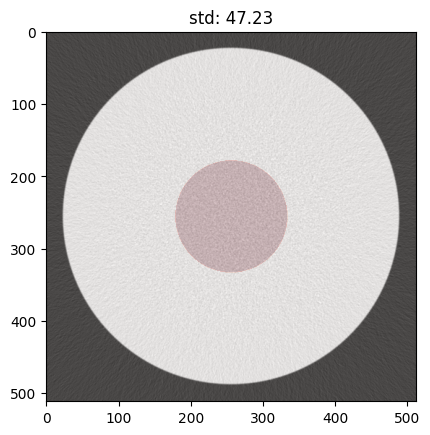

In [12]:
roi = circle_select(vol[0], (vol[0].shape[0]//2, vol[0].shape[1]//2), r/3)
plt.imshow(vol[0], cmap='gray')
plt.imshow(roi, cmap='Reds', alpha=0.2)
plt.title(f'std: {vol[0][roi].std():2.2f}')
plt.show()

In [13]:
denoised = model.predict(vol[:20])

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


In [14]:
denoised[:,roi].std(axis=1).mean()

28.95023

In [15]:
redcnn = load_model(f'models/lambda{int(0):03d}').to(device)

NameError: name 'device' is not defined

In [ ]:
phantom = 'uniform'
doses = []
stds = []
means = []
imgs = []
diams = []
fovs=[]
lambdas = []
recons = []
img_dict = {}

device='cuda'
redcnn = load_model(f'models/lambda{int(0):03d}').to(device)
for recon in ['fbp', 'RED-CNN', 'RED-CNN augmented']:
    for dose in [25, 100]:
        for diam in meta[meta.phantom==phantom]['effective diameter [cm]'].unique():
            rd_vol = load_mhd(meta[(meta['Dose [%]'] == dose) &
                         (meta.phantom == phantom) &
                         (meta['effective diameter [cm]'] == diam)].file.item()) #try different phantom sizes and compare if lambda value changes
            fov=meta[(meta['Dose [%]'] == dose) &
                         (meta.phantom == phantom) &
                         (meta['effective diameter [cm]'] == diam)]['FOV [cm]'].item()
            lambda_dict = {}
            for lmbda in range(11):
                lmbda/=10
                if recon == 'RED-CNN':
                    model_path = Path(f'models/lambda{int(0):03d}')
                else:
                    model_path = Path(f'models/lambda{int(lmbda*100):03d}')
                if (recon == 'fbp'):
                    denoised = rd_vol
                else:
                    model = load_model(model_path).to(device)
                    denoised = model.predict(ld_vol, device=device).squeeze()
                roi = circle_select(rd_vol[0], (rd_vol[0].shape[0]//2, rd_vol[0].shape[1]//2), r/3)
                ctshow(denoised[0])
                plt.imshow(roi, cmap='Reds', alpha=0.05)
                std = denoised[:, roi].std(axis=1).mean()
                mean = denoised[:, roi].std(axis=1).mean()
                plt.title(f'{recon} {dose}% dose\ndiam: {diam} cm, $\lambda$: {lmbda} std: {std:2.2f}')
                plt.show()
                doses.append(dose)
                stds.append(std)
                means.append(mean)
                diams.append(diam)
                lambdas.append(lmbda)
                fovs.append(fov)
                recons.append(recon)
                lambda_dict[lmbda] = denoised[0]
            img_dict[diam] = lambda_dict

In [ ]:
df = pd.DataFrame({'effective diameter [cm]':diams,
                   'FOV [cm]':fovs,
                   'Dose [%]': doses,
                   'recon': recons,
                   'lambda': lambdas,
                   'mean [HU]': means,
                   'std [HU]': stds})
df

Add hi dose and low dose values...

In [ ]:
df['effective diameter [cm]'].unique()

In [ ]:
f, ax = plt.subplots()
for diam in sorted(df['effective diameter [cm]'].unique()):
    df[(df.recon!='fbp')&(df['Dose [%]']==25)&(df.recon=='RED-CNN augmented')&(df['effective diameter [cm]']==diam)].plot(x='lambda', y='std [HU]', label=diam,ax=ax)
plt.show()

In [ ]:
df.columns

In [ ]:
sorted(df['FOV [cm]'].unique())

In [ ]:
means = df.groupby(['recon', 'Dose [%]', 'lambda']).mean()
means

In [ ]:
f, ax = plt.subplots(figsize=(3.5, 3), dpi=150)
means['std [HU]']['fbp', 25].plot(ax=ax, label='fbp low dose')
means['std [HU]']['fbp', 100].plot(ax=ax, label='fbp hi dose')
means['std [HU]']['RED-CNN', 25].plot(ax=ax, label='RED-CNN')
means['std [HU]']['RED-CNN augmented', 25].plot(ax=ax, label='RED-CNN augmented')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('std [HU]')
plt.legend()

In [ ]:
df[(df.recon!='fbp')&(df['Dose [%]']==25)&(df.recon=='RED-CNN augmented')&(df['effective diameter [cm]']==13.1)].plot(x='lambda', y='std [HU]')

In [ ]:
sns.lineplot(data=df[(df.recon!='fbp')&(df['Dose [%]']==25)], x='lambda', y='std [HU]', hue='FOV [cm]', style='Dose [%]')

In [ ]:
f, ax = plt.subplots(dpi=300)
ctshow(np.concatenate([vol[0], imgs[1], rd_vol[0]], axis=1))

In [ ]:
plt.plot(stds)

In [ ]:
noise_patch_dir = Path('../noise_patches')
diameters = [112, 131, 151, 185, 200, 216, 292, 350]
# diameters = [151]
# diameters = [112, 131]

# noise_files = [noise_patch_dir / f'diameter{d}mm.npy' for d in diameters]
# noise_patch_dict = {f.stem: np.load(f) for f in noise_files}
# noise_patches = np.concatenate(list(noise_patch_dict.values()))
# noise_patches = np.zeros_like(noise_patches)

In [ ]:
def load_noise_patch_dict(diameters = [112, 131, 151, 185, 216, 292, 350]):
    noise_files = [noise_patch_dir / f'diameter{d}mm.npy' for d in diameters]
    return {f.stem: np.load(f) for f in noise_files}
    
def load_noise_patches(diameters=[112, 131, 151, 185, 216, 292, 350]):
    noise_patch_dict = load_noise_patch_dict(diameters)
    return np.concatenate(list(noise_patch_dict.values()))

In [ ]:
import sys
sys.path.append('..')
from nps_utils import compute_nps

In [ ]:
example_input = test_input[[3], ...]
edge_buffer = 128
progress_ims = []
progress_val = []

class SaveSampleImageCallback(keras.callbacks.Callback):
    def __init__(self, progress_ims, progress_val):
          super().__init__()
          self.progress_ims = progress_ims
          self.progress_val = progress_val
    def on_epoch_begin(self, epoch, logs=None):
            val_loss = self.model.evaluate(val_input, val_target)
            example_output = self.model.predict(example_input)
            example_img = example_output[0, edge_buffer:-edge_buffer,
                                         edge_buffer:-edge_buffer, 0]
            self.progress_ims.append(example_img)
            self.progress_val.append(val_loss)

In [ ]:
def denoising_size_dependence(model, noise_patch_dict, N=None):
    N = N or len(noise_patch_dict['diameter112mm'])
    return {name: 100*(model.predict(patch_set[:N,:,:,None]).std()-patch_set[:N,:,:,None].std())/patch_set[:N,:,:,None].std() for name, patch_set in noise_patch_dict.items()}
noise_patch_dict = load_noise_patch_dict(diameters = [112, 131, 151, 185, 216, 292, 350])

In [ ]:
noise_patch_dict.keys()

In [ ]:
noise_patch_dict['diameter131mm'][:,:,:,None].shape

In [ ]:
val_input = noise_patch_dict['diameter131mm'][:1000,:,:,None]
val_target = np.zeros_like(val_input)
val_input.shape, val_target.shape

In [ ]:
import datetime
from tensorflow.keras.metrics import RootMeanSquaredError
from functools import partial

rng = tf.random.Generator.from_seed(123, alg='philox')


# This sets the number of iterations through the training data
epochs = 15
batch_size = 32
learning_rate = 0.0001
SHUFFLE_BUFFER_SIZE = 1000
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer = 'adam'

train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

AUTOTUNE = tf.data.AUTOTUNE

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

def train(augment_training=0.7, model=None, epochs=15, noise_textures=[112, 131, 151, 185, 216, 292]):
    'providing `model` as an argument skips model building and compiling and allows fine-tuning with a pretrained model'
  
    noise_patches = load_noise_patches(diameters=noise_textures)
    
    def augment(image_label, seed, aug_thresh = 0.7, max_noise=1):
      'aug_thresh = lambda the frequency of augmentation, 0 = None, 1 = All'
      image, label = image_label
      new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
      noise_patch = noise_patches[np.random.choice(list(range(len(noise_patches))))][:,:,None]
      noise_lambda = tf.random.uniform([1], minval=0, maxval=max_noise)[0]
      add_noise = tf.random.uniform([1], minval=0, maxval=1) < aug_thresh #from 0.5

      if add_noise:
        image = label + noise_lambda*noise_patch
      return image, label

    def f(x, y):
      seed = rng.make_seeds(2)[0]
      image, label = augment((x, y), seed, aug_thresh = augment_training)
      return image, label

    train_ds = (
      train_dataset
      .map(f, num_parallel_calls=AUTOTUNE)
      .prefetch(AUTOTUNE)
    )

    if model is None:
        model = build_model()
        model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
    progress_ims = []
    progress_val = []
    callback = SaveSampleImageCallback(progress_ims, progress_val)
    model.fit(train_ds, epochs = epochs, callbacks=[callback, tensorboard_callback], validation_data=val_dataset)

    progress_ims = np.stack(progress_ims, axis=0)

    print('Training phase complete.')
    return model, np.stack(callback.progress_ims, axis=0), callback.progress_val

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

base_denoising_model, base_progress_ims, base_progress_val = train(augment_training=0, epochs=15)

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
def check_progress_ims(progress_ims):
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 2, 1)
    plt.title('Before Optimization', fontsize=16)
    ctshow(progress_ims[0, :, :], window='variable')

    plt.subplot(2, 2, 2)
    plt.title('Epoch %d/%d' %(1, epochs), fontsize=16)
    ctshow(progress_ims[1, :, :], window='soft_tissue')

    plt.subplot(2, 2, 3)
    plt.title('Epoch %d/%d' %(5, epochs), fontsize=16)
    ctshow(progress_ims[5, :, :], window='soft_tissue')

    plt.subplot(2, 2, 4)
    plt.title('Final Epoch', fontsize=16)
    ctshow(progress_ims[-1, :, :], window='soft_tissue')

In [ ]:
check_progress_ims(base_progress_ims)

## Now with augmentation

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

aug_denoising_model, aug_progress_ims, aug_progress_val = train(augment_training=0.65, epochs=25)

In [ ]:
plt.plot(np.array(base_progress_val)[:, 1],label='cnn')
plt.plot(np.array(aug_progress_val)[:, 1],label='aug')
plt.show()

In [ ]:
check_progress_ims(aug_progress_ims)

In [ ]:
nexample = 2
base_CNNout = base_denoising_model.predict(test_input, batch_size=1)
aug_CNNout = aug_denoising_model.predict(test_input, batch_size=1)

plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[nexample, :, :, 0])


plt.subplot(1, 3, 2)
plt.title('base CNN Denoised Image', fontsize=16)
ctshow(base_CNNout[nexample, :, :, 0])

plt.subplot(1, 3, 3)
plt.title('aug CNN Denoised Image', fontsize=16)
ctshow(aug_CNNout[nexample, :, :, 0])

# Same as above, but with a different field of view
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('base CNN Denoised, MSE', fontsize=16)
ctshow(base_CNNout[3, 110:-110, 50:-50, 0])

plt.subplot(1, 2, 2)
plt.title('aug CNN Denoised, MSE', fontsize=16)
ctshow(aug_CNNout[3, 110:-110, 50:-50, 0])

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 2)
plt.title('Hi Dose Input', fontsize=16)
ctshow(test_target[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 3)
plt.title('base CNN Denoised, MSE', fontsize=16)
ctshow(base_CNNout[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 4)
plt.title('aug CNN Denoised, MSE', fontsize=16)
ctshow(aug_CNNout[3, 110:-110, 50:-50, 0])
# plt.savefig(f'comp_{aug_thresh:0.1f}.png', dpi=150)

Interesting, adding more augmentaton by lowering that threshold reduces overall denoising but improves retention of texture, see how this compares to simply adding back noise to the un-augmented cnn

So far it seems like if I add too much low frequency noise, it destroy  the training and leavee our high frequenices, so I nee to balance the weighting about how many of the traingin images have augmentation while having enough noise reduction

There's a balance between *how much* denoiosing and what frequencies to remove, so it seems like there's 2 parameters to balance

Seems like higher frequency (lower threshold) --> more augmentation and thus lower overall noise reduction, but with better texture

In [ ]:
print("Evaluate")
result = base_denoising_model.evaluate(test_dataset)
dict(zip(base_denoising_model.metrics_names, result))

In [ ]:
result = aug_denoising_model.evaluate(test_dataset)
dict(zip(aug_denoising_model.metrics_names, result))

## Now Data Augmentation as a Fine Tuning Step

Take the pretrained `Simple CNN MSE` then apply the data augmentation. In theory it already knows how to denoise. Will fine tuning be destructive or improve generalizability to more textures?

In [ ]:
aug_pretrained_model, aug_pretrained_progress_ims, aug_pretrained_progress_val = train(augment_training=0.7, model=base_denoising_model, epochs=100)

In [ ]:
check_progress_ims(aug_pretrained_progress_ims)

In [ ]:
plt.plot(np.array(aug_pretrained_progress_val)[:,0])

In [ ]:
aug_pretrainedout = aug_pretrained_model.predict(test_input, batch_size=1)
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.title('aug CNN Denoised, MSE', fontsize=16)
ctshow(aug_CNNout[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 2)
plt.title('Hi Dose Input', fontsize=16)
ctshow(test_target[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 3)
plt.title('base CNN Denoised, MSE', fontsize=16)
ctshow(base_CNNout[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 4)
plt.title('aug pretrained Denoised, MSE', fontsize=16)
ctshow(aug_pretrainedout[3, 110:-110, 50:-50, 0])

In [ ]:
print("Evaluate")
result = base_denoising_model.evaluate(test_dataset)
dict(zip(base_denoising_model.metrics_names, result))

In [ ]:
result = aug_denoising_model.evaluate(test_dataset)
dict(zip(aug_denoising_model.metrics_names, result))

In [ ]:
result = aug_pretrained_model.evaluate(test_dataset)
dict(zip(aug_pretrained_model.metrics_names, result))

## Need to find the right balance between training loss and validation loss other  

Other quesions: how does what noises are iuncluded influence image quality and validation loss